# Emotion recognition group 16
### Members
- Rens Scheepers: 1622749
- Zijian Dong: 2268264
- Timo Vojnic Zelic: 172411

Python version: 3.13.5  

packages used:
- numpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import AffineTransform, warp, rotate
from skimage.feature import hog
from sklearn.svm import SVC

from dataclasses import dataclass

EMOTION_CLASSES = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}


In [2]:
# load the data into dataframes
train_data_raw = pd.read_csv("data/fer2013_train.csv") 
validation_data = pd.read_csv("data/fer2013_validation.csv") 
test_data = pd.read_csv("data/fer2013_test.csv") 

Starting distribution of data per class:
0: Angry: 3995
1: Disgust: 436
2: Fear: 4097
3: Happy: 7215
4: Sad: 4830
5: Surprise: 3171
6: Neutral: 4965


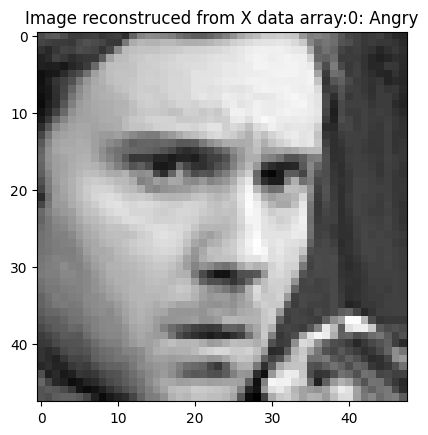

Class 0: +3221 augmented added
Class 1: +6780 augmented added
Class 2: +3119 augmented added
Class 3: +1 augmented added
Class 4: +2386 augmented added
Class 5: +4045 augmented added
Class 6: +2251 augmented added
Distribution of data per class after augmentation:
0: Angry: 7216
1: Disgust: 7216
2: Fear: 7216
3: Happy: 7216
4: Sad: 7216
5: Surprise: 7216
6: Neutral: 7216


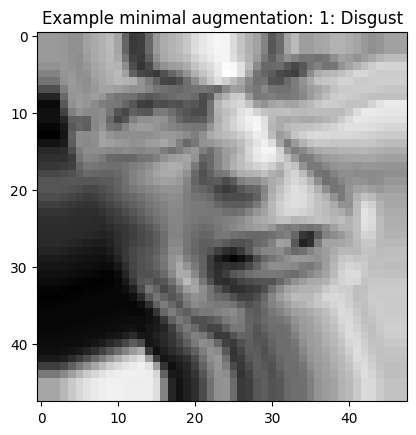

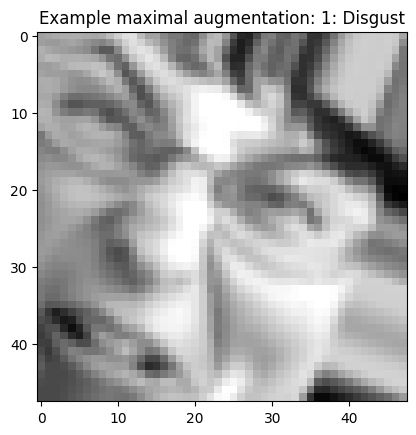

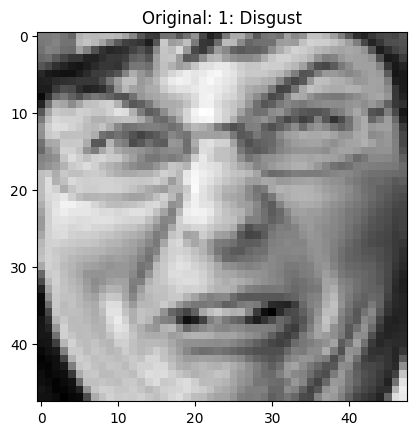

In [5]:
class DataPreperations:
    """
    Augment only the under-represented classes with label preserving transformations.
    Augmentation should reduce variance and improve invariance.
    Invariants:
    - translation 
    - rotation 
    - scaling 
    - lighting 
    - horizontal flip (because faces are horizontally symmetric, they are not vertically symmetric)

    Give class weights to use in training. they correct residual imbalance seen by the loss. 
    It should not have to be used, as augmentation already balances the dataset

    output:
    - self.X_data_augmented
    - self.Y_data_augmented 
    """
    def __init__(self, data: pd.DataFrame, verbose: bool = False):
        self.data = data
        self.verbose = verbose
        self.rng = np.random.default_rng(1712411)

        # the uniformly sampled probability that determines whether an operation is done when augmenting
        self.augment_probabilities = {
            "translation": 0.8,
            "rotate": 0.4,
            "scaling": 0.5,
            "lighting": 0.2,
            "horizontal-flip": 0.5
        }

        # The range in which a uniformly sample value determines the augmentation
        self.augment_range = {
            "translation": (-6,6), # pixels
            "rotate": (-20,20), # degrees
            "scaling": (0.9, 1.1), # factor
            "lighting": (0.75, 1.25) # factor
        }

        self.x_y_split() # generate X_data, Y_data
        self.data_augmentation() # generate X_data_augmented, Y_data_augmented

    # invariant augmentations (use scikit-image):
    def translation(self, X_data:np.ndarray, pixels: tuple[int, int]) -> np.ndarray:
        """ Translate by an amount of pixels (x,y) (stay between 2 and 6)."""
        tx, ty = pixels # amount of pixels to translate in x and y

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            # translation is affine transform
            tform = AffineTransform(translation=(tx, ty))
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data
    
    def rotation(self, X_data:np.ndarray, degrees: float) -> np.ndarray:
        """ Give the image pixels a rotation around the center (stay between -20, 20 degrees)."""
        
        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            augmented = rotate(image, angle=degrees, resize=False, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data

    def scaling(self, X_data:np.ndarray, factor: float) -> np.ndarray:
        """ Scale the image pixels (stay between 0.8 and 1.2 %)"""
        # center image
        height, width = X_data.shape[1], X_data.shape[2]
        cx, cy = width / 2.0, height / 2.0

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            t1 = AffineTransform(translation=(-cx, -cy)) # translate to origin
            s  = AffineTransform(scale=(factor, factor)) # scale by factor
            t2 = AffineTransform(translation=(cx, cy)) # translate back 
            tform = t1 + s + t2
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return  augmented_data
    
    def lighting(self, X_data:np.ndarray, light_intensity: float) -> np.ndarray:
        """ Change the lighting of all pixels (stay between 0.8 and 1.2)."""
        out = (X_data.astype(np.float32) * light_intensity) # change lighting intensity by multiplying with factor
        return np.clip(out, 0.0, 1.0).astype(np.float32) # stay within normalized range

    def horizontal_flip(self, X_data:np.ndarray) -> np.ndarray:
        """ flip over the y axis """
        return np.flip(X_data,axis=2)
    
    # building up X and Y for feature extraction:
    def x_y_split(self) -> tuple[np.ndarray, np.ndarray]:
        """Turn the dataframe into X and Y arrays
        optionally print the distribution per class to good a sense of class representation in the data. """
        # turn dataframe into numpy array with grayscale values
        X_data = np.array([np.fromstring(pixels, sep=' ') for pixels in self.data['pixels']]) 
        # normalize X_data [0,255] to [0,1]
        X_data = X_data.astype(np.float32)  / 255.0
        # get X data into 48x48 image pixel grid 
        self.X_data = X_data.reshape(-1, 48, 48)
        
        # get numeric class labels into numpy array
        self.Y_data = np.array(self.data['emotion'].values)
        if self.verbose:
            # count how many items are in the data set for each class 
            unique, counts = np.unique(self.Y_data, return_counts=True)
            print("Starting distribution of data per class:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")

            plt.imshow(self.X_data[0], cmap='gray')
            plt.title(f"Image reconstruced from X data array:{EMOTION_CLASSES[self.Y_data[0]]}")
            plt.show()
    
    def data_augmentation(self):
        """ Combine the invariant operations to balance out under under represented classes.
        Randomly perform augmentations, the probabilities can be changed in class configuration."""
        classes, counts = np.unique(self.Y_data, return_counts=True)
        target_image_n = counts.max() # aim for every class to have the same amount of images as the largest class has

        # make lists to append
        X_out = [self.X_data]
        Y_out = [self.Y_data]

        for c, n in zip(classes, counts): # iterate over classes and amount of images they have
            images_needed = target_image_n - n + 1 # make at least one augment image for the class with the most images
            
            class_indexes = np.where(self.Y_data==c)[0] # select the images of the current class
            augmented_images = []

            for _ in range(images_needed):
                index = int(self.rng.choice(class_indexes)) # pick a random image to augment
                img = self.X_data[index][None, ...]  # shape (1,48,48) to use the X_data input

                # apply augmentations based on probabilities
                if self.rng.random() < self.augment_probabilities["translation"]:
                    # apply translation if random number is below threshold probability
                    lo, hi = self.augment_range["translation"]   # (0.8, 1.2)
                    tx = int(self.rng.uniform(lo, hi))
                    ty = int(self.rng.uniform(lo, hi))
                    img = self.translation(img, (tx, ty)) 
                
                if self.rng.random() < self.augment_probabilities["rotate"]:
                    lo, hi = self.augment_range["rotate"]    
                    degree = float(self.rng.uniform(lo, hi))
                    img = self.rotation(img, degree) 

                if self.rng.random() < self.augment_probabilities["scaling"]:
                    lo, hi = self.augment_range["scaling"]   
                    factor = float(self.rng.uniform(lo, hi))
                    img = self.scaling(img, factor) 

                if self.rng.random() < self.augment_probabilities["lighting"]:
                    lo, hi = self.augment_range["lighting"]  
                    light_intensity = float(self.rng.uniform(lo, hi))
                    img = self.lighting(img, light_intensity) 

                if self.rng.random() < self.augment_probabilities["horizontal-flip"]:
                    img = self.horizontal_flip(img)
                
                augmented_images.append(img[0]) # add to list

            # save images in X,Y format
            aug_imgs = np.stack(augmented_images, axis=0).astype(np.float32)
            aug_labels = np.full(images_needed, c, dtype=self.Y_data.dtype)

            X_out.append(aug_imgs)
            Y_out.append(aug_labels)
            
            # print how many images where added with augmentation
            if self.verbose:
                print(f"Class {c}: +{images_needed} augmented added")
        
        self.X_data_augmented = np.concatenate(X_out, axis=0).astype(np.float32)
        self.Y_data_augmented = np.concatenate(Y_out, axis=0)

        # summary of resulting distributions per class
        if self.verbose:
            unique, counts = np.unique(self.Y_data_augmented, return_counts=True)
            print("Distribution of data per class after augmentation:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")
        
        # show what augmentation is doing
        if self.verbose:
            class_select = 1 # 1 = disgust
            class_indexes = np.where(self.Y_data==class_select)[0]
            img = self.X_data[class_indexes[0]][None, ...] # get the first image for disgust

            min_params = {
                "translate": (self.augment_range["translation"][0], self.augment_range["translation"][0]),
                "rotate": self.augment_range["rotate"][0],
                "scaling": self.augment_range["scaling"][0],
                "lighting": self.augment_range["lighting"][0]
            }

            max_params = {
                "translate": (self.augment_range["translation"][1], self.augment_range["translation"][1]),
                "rotate": self.augment_range["rotate"][1],
                "scaling": self.augment_range["scaling"][1],
                "lighting": self.augment_range["lighting"][1]
            }

            # apply all augmentations
            for label, params in [("minimal", min_params), ("maximal", max_params)]:
                img_aug = self.translation(img, params["translate"])
                img_aug = self.rotation(img_aug, params["rotate"])
                img_aug = self.scaling(img_aug, params["scaling"])
                img_aug = self.lighting(img_aug, params["lighting"])
                img_aug = self.horizontal_flip(img_aug)

                plt.imshow(img_aug[0], cmap="gray")  # show 2D
                plt.title(f"Example {label} augmentation: {EMOTION_CLASSES[class_select]}")
                plt.show()

            # Show original for reference
            plt.imshow(img[0], cmap="gray")
            plt.title(f"Original: {EMOTION_CLASSES[class_select]}")
            plt.show()
    
    def class_weights(self):
        """ Use sklearns tool to get class weights based on the augmented Y data labels """
        classes = np.unique(self.Y_data_augmented)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=self.Y_data_augmented)
        class_weight_dict = {c:w for c, w in zip(classes, class_weights)}
        print("Class weights for training")
        if self.verbose:
            for c, w in class_weight_dict:
                print(f"{EMOTION_CLASSES[c]}: {w}")
        return class_weight_dict
    
train_data = DataPreperations(train_data_raw, verbose=True)


### Feature Extraction

In [ ]:
class FeatureExtraction:
    """
    The data comes in as 48x48 values between 0 and 1; it is 2304 dimensional and has high entropy.
    Intuitivly what indicates an emotion in the original representation is:
    - mouth position
    - eye size
    - eyebrow position
    These things are indicated with regions of contrasting greyscale 

    The features that are used are:
    - HOG (historgram of oriented gradients)
        - encodes local edge direction and contrast: gives edges and contours of facial features
    - LBP (local binary pattern)
    
    """
    def __init__(self):
        pass


X_train_hog = [hog(img, pixels_per_cell=(8,8)) for img in X_train]

NameError: name 'X_train' is not defined

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
# X_val_scaled = scaler.transform(X_val_hog)

In [ ]:

# model_svm = SVC(kernel='rbf', class_weight='balanced')
# model_svm.fit(X_train_scaled, y_train)

: 

: 